# Robustness Analysis: Adjoint and Toggle-Frame Objectives Subject to Either Multiplicative or Additive Errors

This notebook compares the performance of the adjoint and toggling-frame robustness objectives for multiplicative and additive error terms in the system's Hamiltonian. 

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs fo

In [2]:
# Problem parameters
T = 20
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 3

sanity checks for our good ole adjoint

In [3]:
propertynames(sys)

(:H, :G, :n_drives, :levels, :params)

In [4]:
typeof(sys.H)

PiccoloQuantumObjects.QuantumSystems.var"#6#15"{SparseMatrixCSC{ComplexF64, Int64}, Vector{SparseMatrixCSC{ComplexF64, Int64}}}

In [5]:
length(sys.H.H_drives)
X_drive = sys.H.H_drives[1]
X_drive === H_drive[1]

false

In [6]:
Random.seed!(5)
uni_prob = UnitaryUniversalProblem(
    sys, U_goal, T, Δt;
    piccolo_options=piccolo_opts
    )

solve!(uni_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(uni_prob, max_iter=20, print_level=5)

f_uni_prob = UnitaryUniversalProblem(
    sys, U_goal, T, Δt;
    activate_speedboost=true,
    piccolo_options=piccolo_opts
    )
solve!(f_uni_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(f_uni_prob, max_iter=20, print_level=5)

# rf_uni_prob = UnitaryUniversalProblem(
# sys, U_goal, T, Δt;
# piccolo_options=piccolo_opts
# )
# solve!(rf_uni_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
# solve!(rf_uni_prob, max_iter=20, print_level=5)

#Default
def = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; Q_t=1.0)
solve!(def, max_iter=500, print_level=1, options=IpoptOptions(eval_hessian=false))
solve!(def, max_iter=20, print_level=5)

#Adjoint
∂ₑHₐ = PAULIS.X
varsys_add = VariationalQuantumSystem(
    H_drive,
    [PAULIS.X, PAULIS.Y, PAULIS.Z]
)

# Multiplicative error template
# H = aX
# H_drive_m = a -> a[1] * H_drive
# H_vars_array = Function[H_drive_m]

varsys_mult = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    Function[a -> a[1] * PAULIS.X],
    2
)

varsys_both = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    Function[a -> a[1] * PAULIS.X, a -> PAULIS.X],
    2
)

varadd_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        robust_times=[[T]],
        dda_bound = 2.0,
        piccolo_options=piccolo_opts
    )

solve!(varadd_prob, max_iter=500, print_level=1, options=IpoptOptions(eval_hessian=false))
solve!(varadd_prob, max_iter=20, print_level=5)


    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:     2376
Number of nonzeros in inequality constraint Jacobian.:        0
Number of no

In [7]:
# Random.seed!(5)
# uni_prob = UnitaryUniversalProblem(
#     sys, U_goal, T, Δt;
#     piccolo_options=piccolo_opts
#     )
# solve!(uni_prob, max_iter=150, print_level=5)

# #Default
# def = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; Q_t=1.0)
# solve!(def, max_iter=250, print_level=5)

# #Adjoint
# ∂ₑHₐ = PAULIS.X
# varsys_add = VariationalQuantumSystem(
#     H_drive,
#     [∂ₑHₐ]
# )

# # Multiplicative error template
# # H = aX
# # H_drive_m = a -> a[1] * H_drive
# # H_vars_array = Function[H_drive_m]

# varsys_mult = VariationalQuantumSystem(
#     a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
#     Function[a -> a[1] * PAULIS.X],
#     2
# )

# varsys_both = VariationalQuantumSystem(
#     a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
#     Function[a -> a[1] * PAULIS.X, a -> PAULIS.X],
#     2
# )

# varadd_prob = UnitaryVariationalProblem(
#         varsys_add, U_goal, T, Δt;
#         robust_times=[[T]],
#         dda_bound = 2.0,
#         piccolo_options=piccolo_opts
#     )
# solve!(varadd_prob, max_iter=250, print_level=5)

# # varmult_prob = UnitaryVariationalProblem(
# #         varsys_mult, U_goal, T, Δt;
# #         robust_times=[[T]],
# #         dda_bound = 2.0,
# #         piccolo_options=piccolo_opts
# #     )
# # solve!(varmult_prob, max_iter=250, print_level=5)

# # varboth_prob = UnitaryVariationalProblem(
# #         varsys_both, U_goal, T, Δt;
# #         robust_times=[[T]],
# #         dda_bound = 2.0,
# #         piccolo_options=piccolo_opts
# #     )
# # solve!(varboth_prob, max_iter=250, print_level=5)

# #Toggling

# # Hₑ_add = a -> PAULIS.X
# # add_prob = UnitaryToggleProblem(
# #     sys, U_goal, T, Δt, Hₑ_add;
# #     piccolo_options=piccolo_opts
# #     )
# # solve!(add_prob, max_iter=150, print_level=5)

# # X_drive = sys.H.H_drives[1]
# # Hₑ_mult = a -> a[1] * X_drive

# # mult_prob = UnitaryToggleProblem(
# #     sys, U_goal, T, Δt, Hₑ_mult;
# #     piccolo_options=piccolo_opts
# #     )
# # solve!(mult_prob, max_iter=250, print_level=5)


# # Hₑ_both = a -> PAULIS.X + a[1] * X_drive
# # both_prob = UnitaryToggleProblem(
# #     sys, U_goal, T, Δt, Hₑ_both;
# #     piccolo_options=piccolo_opts
# #     )
# # solve!(both_prob, max_iter=250, print_level=5)




In [8]:
# display(CairoMakie.plot(def.trajectory, :a))
# display(CairoMakie.plot(add_prob.trajectory, :a))
# display(CairoMakie.plot(mult_prob.trajectory, :a))
# display(CairoMakie.plot(both_prob.trajectory, :a))

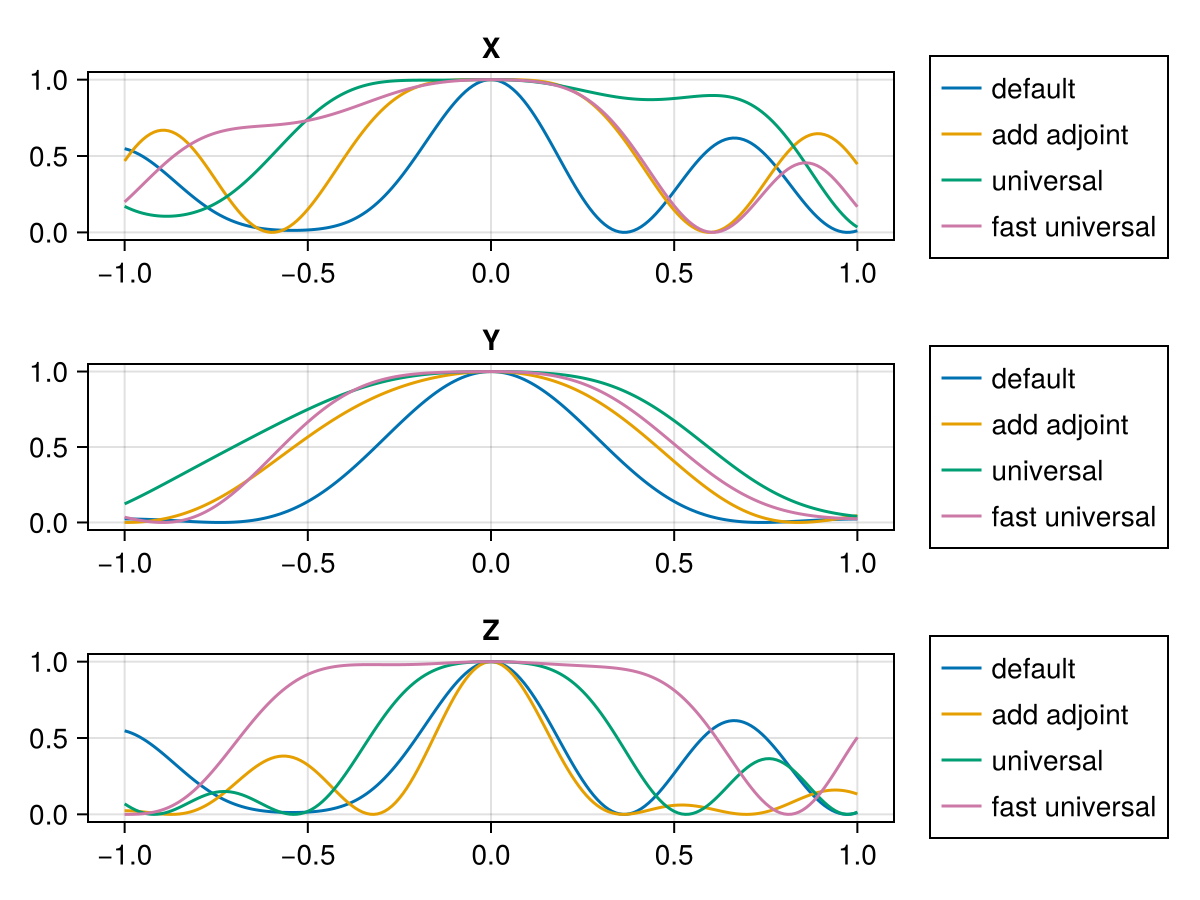

In [9]:
H_drive_add = H_drive  # (kept from your snippet, though it's unused below)

f = Figure()
axX = Axis(f[1, 1], title = "X")
axY = Axis(f[2, 1], title = "Y")
axZ = Axis(f[3, 1], title = "Z")

colors = Makie.wong_colors()
εs = -1:0.01:1

basis = [PAULIS.X, PAULIS.Y, PAULIS.Z]

axes_paulis = [
    (axX, PAULIS.X),
    (axY, PAULIS.Y),
    (axZ, PAULIS.Z),
]

problems = [
    (def,        "default"),
    (varadd_prob, "add adjoint"),
    (uni_prob,   "universal"),
    (f_uni_prob, "fast universal"),
    # (rf_uni_prob,"really fast universal"),
]

# Helper to compute the curve once per (problem, Pauli)
fidelity_curve(prob, pauli) = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem(ε * pauli, basis)) for ε in εs]

# Plot everything with two compact loops
for (ax, pauli) in axes_paulis
    for (i, (prob, label)) in enumerate(problems)
        ys = fidelity_curve(prob, pauli)
        lines!(ax, εs, ys; label = label, color = colors[i], linestyle = :solid)
    end
end

Legend(f[1, 2], axX, position = :lb)
Legend(f[2, 2], axY, position = :lb)
Legend(f[3, 2], axZ, position = :lb)

f


# Verify first-order robustness with space curve approach

In [10]:
uni_prob.trajectory

T = 20, (Ũ⃗ = 1:8, a = 9:11, da = 12:14, dda = 15:17, → Δt = 18:18)

In [11]:
using NamedTrajectories

uni_traj = uni_prob.trajectory
default_traj = def.trajectory

function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * Hₑ * U
        first_order_terms[i] = first_order_integral
    end
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t])),
                    real(tr(PAULIS.Y * first_order_terms[t])),
                    real(tr(PAULIS.Z * first_order_terms[t]))] for t in 1:T] 
    return space_curve
end

SpaceCurve (generic function with 1 method)

In [12]:
uni_curve = SpaceCurve(uni_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

UndefVarError: UndefVarError: `Hₑ` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

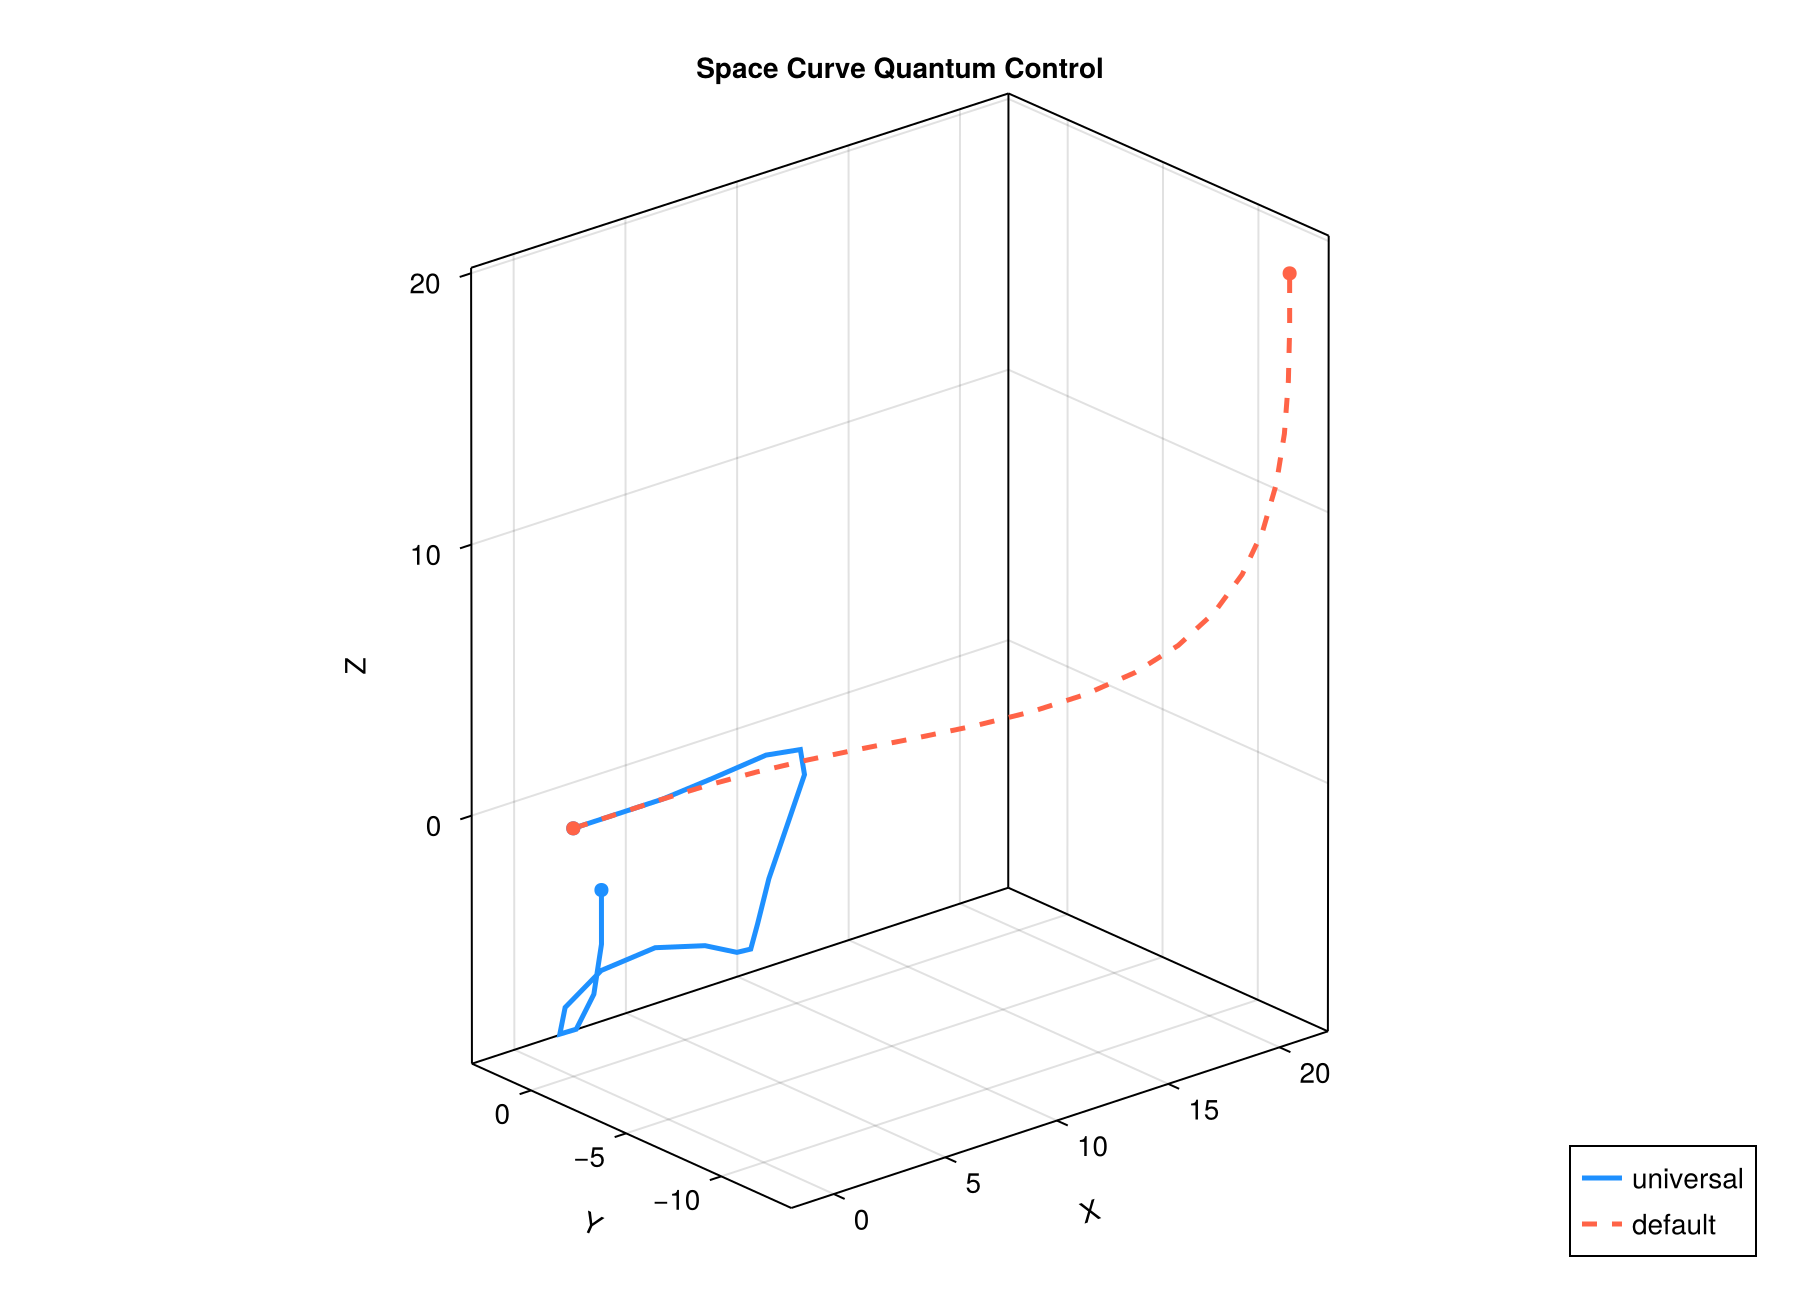

CairoMakie.Screen{IMAGE}


In [13]:
using CairoMakie
const CM = CairoMakie

function to_xyz(curve)
    if curve isa AbstractMatrix
        M = Float64.(real.(curve))
        if size(M, 2) == 3
            x, y, z = M[:, 1], M[:, 2], M[:, 3]
        elseif size(M, 1) == 3
            x, y, z = M[1, :], M[2, :], M[3, :]
        else
            error("Matrix curve must be T×3 or 3×T, got $(size(M))")
        end
    else
        x = Float64.(real.(getindex.(curve, 1)))
        y = Float64.(real.(getindex.(curve, 2)))
        z = Float64.(real.(getindex.(curve, 3)))
    end
    mask = isfinite.(x) .& isfinite.(y) .& isfinite.(z)
    return x[mask], y[mask], z[mask]
end

Hₑ = PAULIS.X

uni_curve     = SpaceCurve(uni_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

x1, y1, z1 = to_xyz(uni_curve)
x2, y2, z2 = to_xyz(default_curve)

pushfirst!(x1, 0.0)
pushfirst!(y1, 0.0)
pushfirst!(z1, 0.0)
pushfirst!(x2, 0.0)
pushfirst!(y2, 0.0)
pushfirst!(z2, 0.0)

f  = CM.Figure(size = (900, 650))
ax = CM.Axis3(f[1, 1];
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    title = "Space Curve Quantum Control", aspect = :data
)

CM.lines!(ax, x1, y1, z1; linewidth = 2.5, color = :dodgerblue, label = "universal")
CM.lines!(ax, x2, y2, z2; linewidth = 2.5, linestyle = :dash, color = :tomato, label = "default")

CM.scatter!(ax, [x1[1]],  [y1[1]],  [z1[1]];  markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x1[end]],[y1[end]],[z1[end]]; markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x2[1]],  [y2[1]],  [z2[1]];  markersize = 10, color = :tomato)
CM.scatter!(ax, [x2[end]],[y2[end]],[z2[end]]; markersize = 10, color = :tomato)

CM.axislegend(ax; position = :rb)

display(f)

     

In [ ]:
using CairoMakie
const CM = CairoMakie

function curves_for(He_sym)
    global Hₑ = He_sym
    uni_curve     = SpaceCurve(uni_traj,     U_goal, He_sym)
    default_curve = SpaceCurve(default_traj, U_goal, He_sym)
    return uni_curve, default_curve
end

function plot_pair!(pos, He_sym, ttl)
    uni_curve, default_curve = curves_for(He_sym)

    x1,y1,z1 = to_xyz(uni_curve)
    x2,y2,z2 = to_xyz(default_curve)

    pushfirst!(x1,0.0); pushfirst!(y1,0.0); pushfirst!(z1,0.0)
    pushfirst!(x2,0.0); pushfirst!(y2,0.0); pushfirst!(z2,0.0)

    ax = CM.Axis3(pos; xlabel="X", ylabel="Y", zlabel="Z", title=ttl, aspect=:data)
    CM.lines!(ax, x1,y1,z1; linewidth=2.5, color=:dodgerblue, label="universal")
    CM.lines!(ax, x2,y2,z2; linewidth=2.5, linestyle=:dash, color=:tomato, label="default")
    CM.scatter!(ax, [x1[1]], [y1[1]], [z1[1]]; markersize=10, color=:dodgerblue)
    CM.scatter!(ax, [x1[end]], [y1[end]], [z1[end]]; markersize=10, color=:dodgerblue)
    CM.scatter!(ax, [x2[1]], [y2[1]], [z2[1]]; markersize=10, color=:tomato)
    CM.scatter!(ax, [x2[end]], [y2[end]], [z2[end]]; markersize=10, color=:tomato)
    CM.axislegend(ax; position=:rt)
    return ax
end

f = CM.Figure(size=(1400, 500))
plot_pair!(f[1,1], PAULIS.X, "Hₑ = X")
plot_pair!(f[1,2], PAULIS.Y, "Hₑ = Y")
plot_pair!(f[1,3], PAULIS.Z, "Hₑ = Z")
display(f)

In [ ]:
ket_0 = [1.0,0.0]

rho_0 = ket_0 * ket_0'

expect_val_x = [real(tr(PAULIS.X * iso_vec_to_operator(uni_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(uni_traj.Ũ⃗[:, t])')) for t in 1:uni_traj.T]
expect_val_y = [real(tr(PAULIS.Y * iso_vec_to_operator(uni_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(uni_traj.Ũ⃗[:, t])')) for t in 1:uni_traj.T]
expect_val_z = [real(tr(PAULIS.Z * iso_vec_to_operator(uni_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(uni_traj.Ũ⃗[:, t])')) for t in 1:uni_traj.T]
expect_val_x_1 = [real(tr(PAULIS.X * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_y_1 = [real(tr(PAULIS.Y * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_z_1 = [real(tr(PAULIS.Z * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]

     

In [ ]:
using CairoMakie
using GeometryBasics

f  = CairoMakie.Figure(resolution = (800, 600))
ax = CairoMakie.Axis3(f[1, 1];
    aspect = :equal
)

palette = to_colormap(:tab10)
styles  = (:solid, :dash, :dot, :dashdot)

origins = [Point3f(0,0,0), Point3f(0,0,0), Point3f(0,0,0)]
dirs    = [Vec3f(1.0,0,0), Vec3f(0,1.0,0), Vec3f(0,0,1.0)]

CairoMakie.arrows!(ax, origins, dirs;
    color = [:red, :green, :blue],
    arrowsize = 0.05,
    linewidth = 0.01
)

CairoMakie.text!(ax, "x", position = Point3f(1.2, 0, 0), align = (:left, :center),  color = :red,   fontsize = 28)
CairoMakie.text!(ax, "y", position = Point3f(0, 1.2, 0), align = (:center, :bottom), color = :green, fontsize = 28)
CairoMakie.text!(ax, "z", position = Point3f(0, 0, 1.2), align = (:center, :bottom), color = :blue,  fontsize = 28)

CairoMakie.lines!(ax, real.(expect_val_x), real.(expect_val_y), real.(expect_val_z);
    color     = palette[1],
    linestyle = styles[1],
    label     = "|0⟩ to |+⟩, default",
    linewidth = 1.5
)

CairoMakie.lines!(ax, real.(expect_val_x_1), real.(expect_val_y_1), real.(expect_val_z_1);
    color     = palette[2],
    linestyle = styles[1],
    label     = "|0⟩ to |+⟩, robust",
    linewidth = 1.5
)

CairoMakie.scatter!(ax, [real(expect_val_x[end])], [real(expect_val_y[end])], [real(expect_val_z[end])];
    color = palette[1], markersize = 20, marker = :xcross)

CairoMakie.scatter!(ax, [real(expect_val_x_1[end])], [real(expect_val_y_1[end])], [real(expect_val_z_1[end])];
    color = palette[2], markersize = 15, marker = :circle)

CairoMakie.mesh!(ax, Sphere(Point3f(0,0,0), 1f0);
    color = (0.2, 0.6, 1.0, 0.05),
    transparency = true,
    shading = true
)

CairoMakie.xlims!(ax, -1.3, 1.3)
CairoMakie.ylims!(ax, -1.3, 1.3)
CairoMakie.zlims!(ax, -1.3, 1.3)

ax.azimuth[]   =  π/4
ax.elevation[] =  π/6

CairoMakie.axislegend(ax; position = :rt)
CairoMakie.hidexdecorations!(ax, grid = false)
CairoMakie.hideydecorations!(ax, grid = false)
CairoMakie.hidezdecorations!(ax, grid = false)

f
     

In [ ]:
using Pkg
Pkg.activate(".")